# La2CuO4

We calculate the Green function of an effective impurity model for La2CuO4.

In [1]:
# %load model.py
import sys
import os

import numpy as np
sys.path.append(os.getcwd() + '/../common')

from triqs.gf import BlockGf, MeshImFreq, MeshReFreq, Omega, iOmega_n, inverse, MeshBrZone, MeshProduct
from triqs.lattice import BrillouinZone
from triqs.operators import c, c_dag
from triqs.operators.util import h_int_kanamori, U_matrix_kanamori
import numpy.linalg as linalg

from triqs.lattice.utils import TB_from_wannier90

# ==== System Parameters ====
beta = 25.                     # Inverse temperature
mu = 14.86                      # Chemical potential
eta = 2e-1

U = 3.6                         # Density-density interaction

n_iw = int(10 * beta)           # The number of positive Matsubara frequencies
n_w = 3001
window = [-10,10]
n_k = 41                        # The number of k-points per dimensio

block_names = ['up', 'dn']       # The spins
n_orb = 1

paths = [os.getcwd()]
for p in paths:
    if os.path.isfile(p + '/lco_hr.dat'):
        path = p
        break
TBL = TB_from_wannier90(seed='/lco', path=path)
TBL.bz = BrillouinZone(TBL.bl)


# ==== Local Hamiltonian ====
c_dag_vec = { s: np.matrix([[c_dag(s,o) for o in range(n_orb)]]) for s in block_names }
c_vec =     { s: np.matrix([[c(s,o)] for o in range(n_orb)]) for s in block_names }

h_0_mat = TBL.hoppings[(0,0,0)][0:n_orb,0:n_orb]
h_0 = sum(c_dag_vec[s] * h_0_mat * c_vec[s] for s in block_names)[0,0]

Umat, Upmat = U_matrix_kanamori(n_orb, U_int=U, J_hund=0.)
h_int = h_int_kanamori(block_names, n_orb, Umat, Upmat, 0.0, off_diag=True)

h_imp = h_0 + h_int

# ==== Non-Interacting Impurity Green function  ====
gf_struct = [ (s,n_orb) for s in block_names ]

iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
w_mesh = MeshReFreq(window, n_w)
k_mesh = MeshBrZone(TBL.bz, n_k)
k_iw_mesh = MeshProduct(k_mesh, iw_mesh)
k_w_mesh = MeshProduct(k_mesh, w_mesh)

G0_k_iw = BlockGf(mesh=k_iw_mesh, gf_struct=gf_struct)
G0_iw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
G0_k_w = BlockGf(mesh=k_w_mesh, gf_struct=gf_struct)
G0_w = BlockGf(mesh=w_mesh, gf_struct=gf_struct)

iw_vec = np.array([iw.value * np.eye(n_orb) for iw in iw_mesh])
w_vec = np.array([w.value * np.eye(n_orb) for w in w_mesh])
e_k = TBL.fourier(k_mesh)[0:n_orb,0:n_orb]
mu_mat = mu * np.eye(n_orb)
eta_mat = 1j * eta * np.eye(n_orb)

for s in block_names:
    G0_k_iw[s].data[:] = linalg.inv(iw_vec[None,...] + mu_mat[None,None,...] - e_k.data[::,None,...])
    G0_iw[s].data[:] = np.sum(G0_k_iw[s].data[:], axis=0) / len(k_mesh)

    G0_k_w[s].data[:] = linalg.inv(w_vec[None,...] + mu_mat[None,None,...] - e_k.data[::,None,...] + eta_mat[None, None, ...])
    G0_w[s].data[:] = np.sum(G0_k_w[s].data[:], axis=0) / len(k_mesh)


# ==== Hybridization Function ====
Delta_iw = G0_iw.copy()
Delta_iw['up'] << iOmega_n + mu_mat - h_0_mat - inverse(G0_iw['up'])
Delta_iw['dn'] << iOmega_n + mu_mat - h_0_mat - inverse(G0_iw['dn'])

# ReFreq Delta
Delta_w = G0_w.copy()
Delta_w['up'] << Omega + mu_mat - h_0_mat - inverse(G0_w['up'])
Delta_w['dn'] << Omega + mu_mat - h_0_mat - inverse(G0_w['dn'])


/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/29h1dijh98y9ar6n8hxv78v8zz2pqfzf-python-3.11.7-view/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <clas

Starting serial run at: 2024-07-08 14:11:59.901947


Greens Function G_dn with mesh Real Freq Mesh with w_min = -10, w_max = 10, n_w = 3001 and target_shape (1, 1): 

## Results Matsubara / imaginary time


In [2]:
from triqs.plot.mpl_interface import oplot, plt
%matplotlib inline

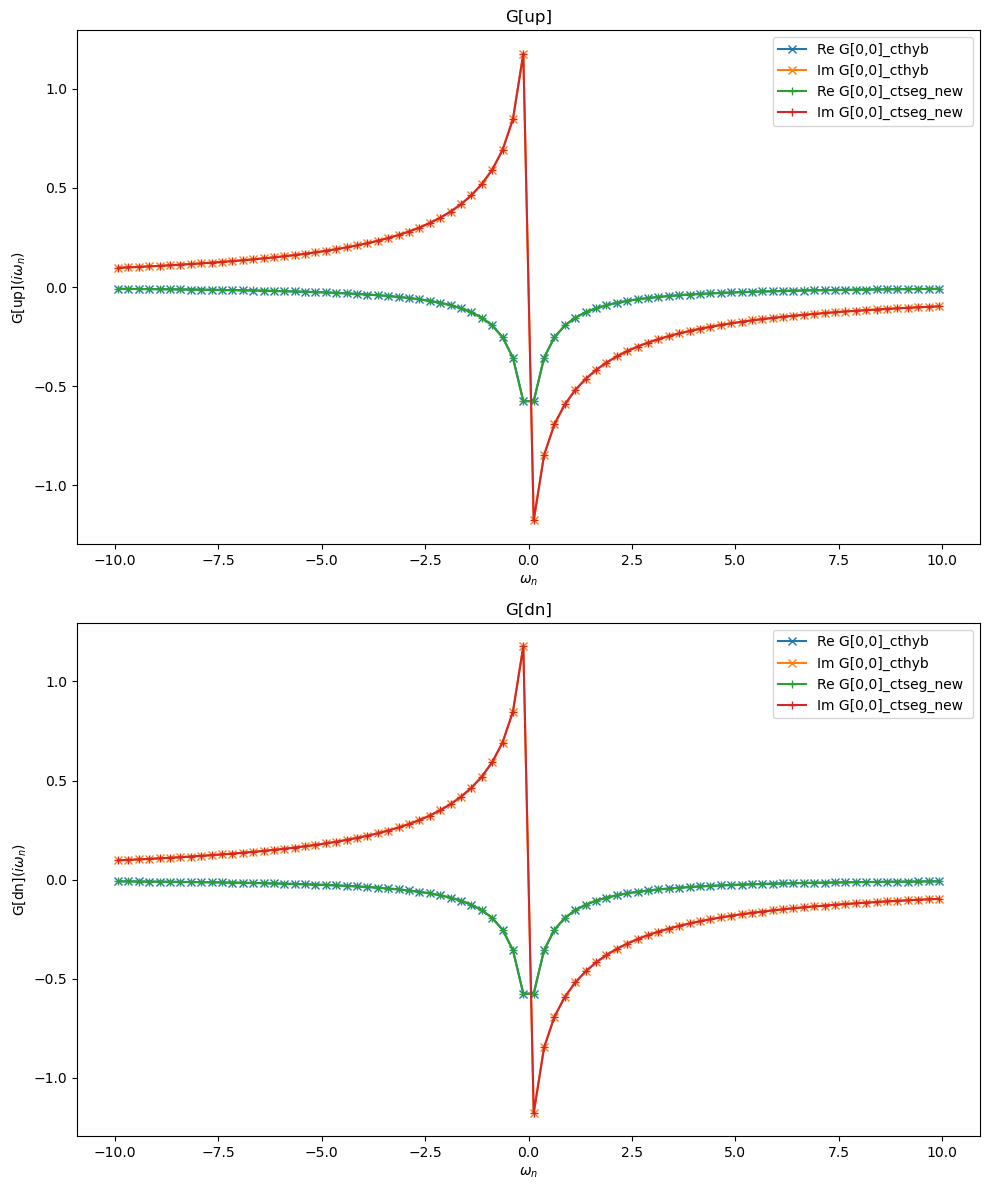

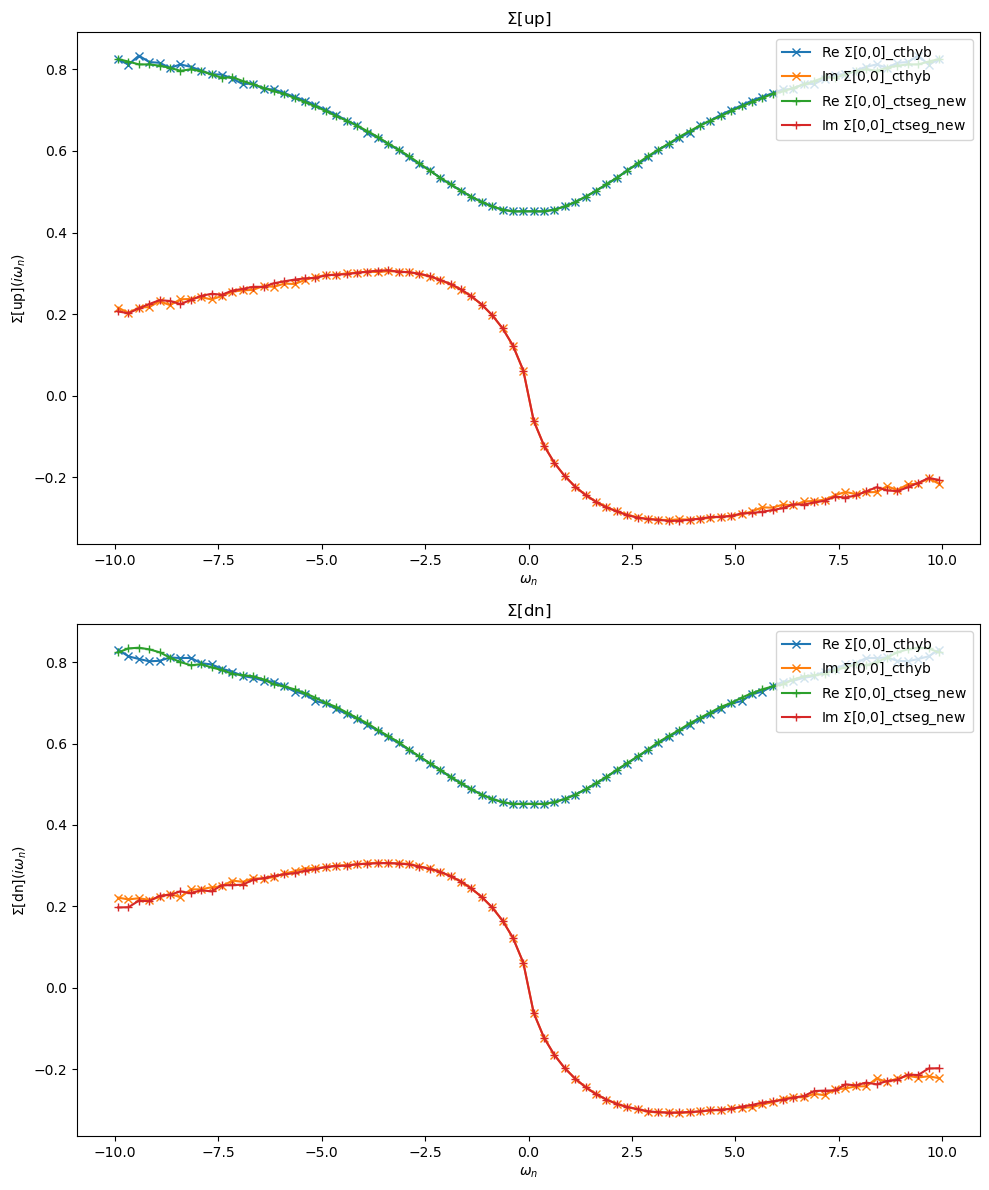

In [3]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy


marker_lst = ['-x', '-+', '-^', '-v', '-<', '->', '-*', '-p']
G, Sigma = {}, {}

solver_lst = ['cthyb', 'ctseg_new']
for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])
    #Sigma[solver] = dat['G_tau']

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, r'$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            marker = marker_lst[solver_lst.index(solver)]
            oplot(g[solver][block][0,0], marker, name = name + "[0,0]_%s" % solver, x_window=(-10,10))
        plt.xlabel(r"$\omega_n$")
        plt.ylabel(name + "[" + block + r"]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


## Deviations

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]

    print("\t\t    Deviations for Block " + block)
    print("\t\t -----------------------------------")

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print(row_format.format("", *solver_lst))
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print(row_format.format(solver, *row))

    print("\n\n")

		    Deviations for Block up
		 -----------------------------------
                         cthyb      ctseg_new
          cthyb       0.00E+00       2.98E-04
      ctseg_new       2.98E-04       0.00E+00



		    Deviations for Block dn
		 -----------------------------------
                         cthyb      ctseg_new
          cthyb       0.00E+00       3.43E-04
      ctseg_new       3.43E-04       0.00E+00





## Results real frequency / real time


0 up


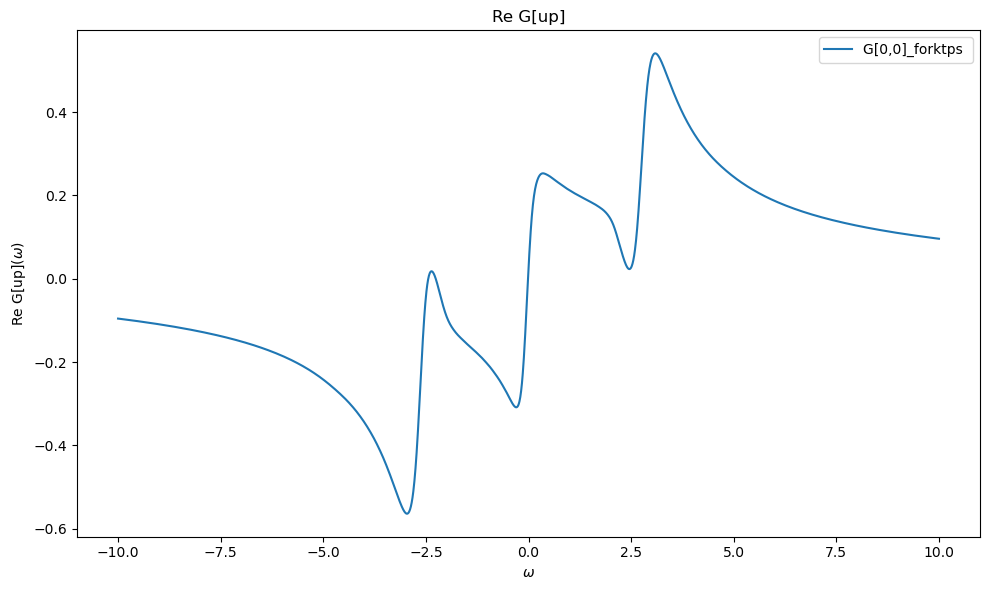

0 up


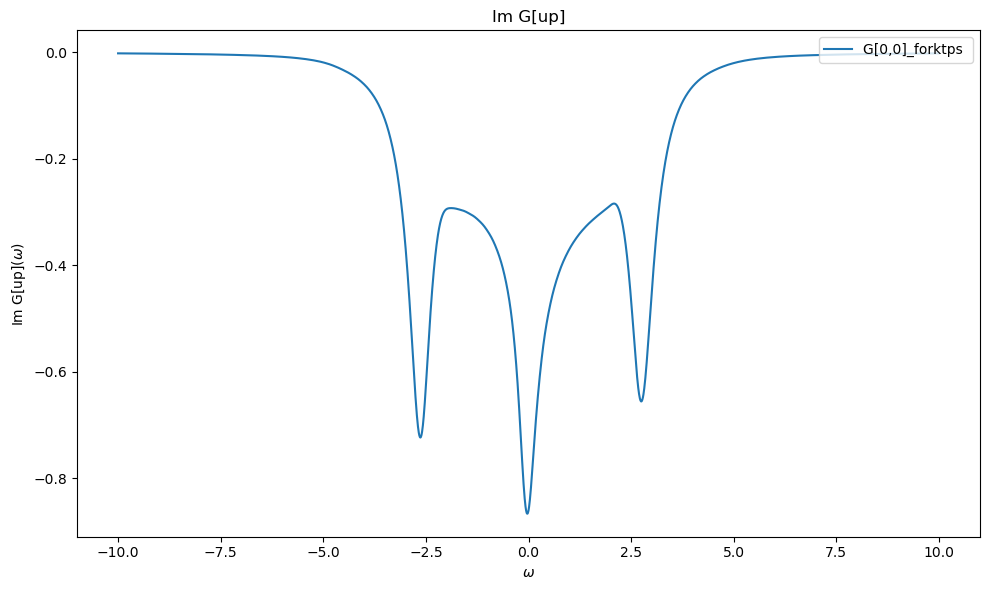

0 up


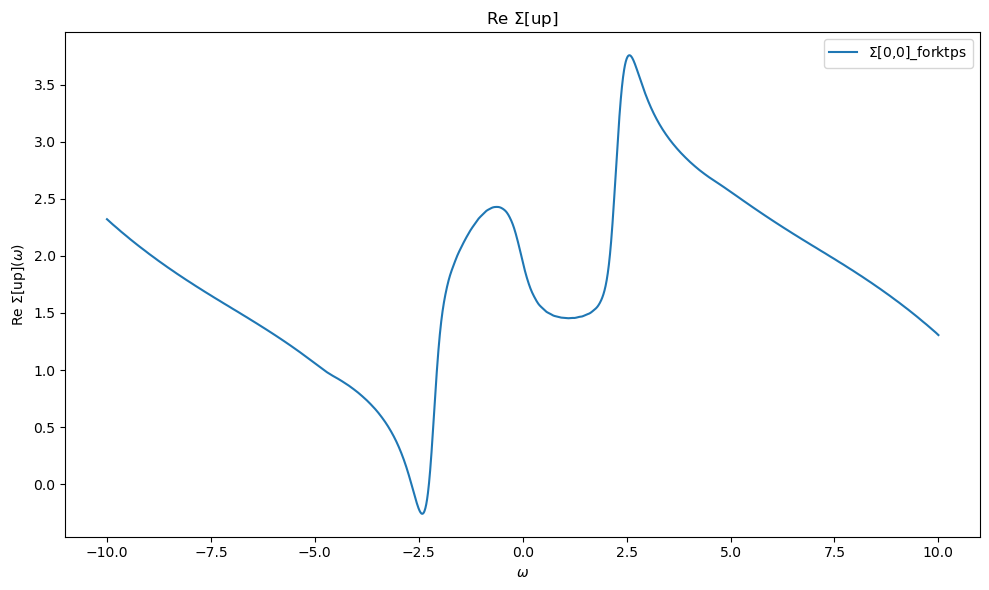

0 up


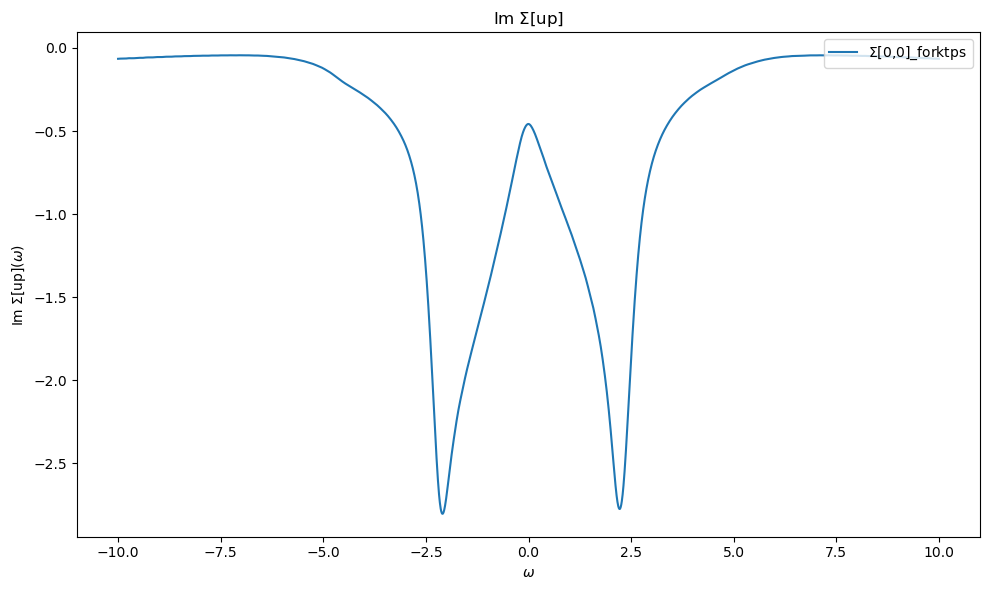

In [5]:
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy
G, G_ret, Sigma = {}, {}, {}

solver_lst = ['forktps']
for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    # G_ret[solver] = dat['Gtime']
    Sigma[solver] = dat['Sigma']


# === For every block and solver, plot Green function and Self energy

block_lst = ['up']
n_blocks = 1

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst):
        print(i,block)
        fig = plt.subplot(n_blocks,1,1)
        fig.set_title("Re " + name + "[" + block + "]")
        for solver in solver_lst:
            block = list(G[solver].indices)[0]
            oplot(g[solver][block][0,0].real, '-', name = name + "[0,0]_%s" % solver, x_window=(-10,10))
        plt.xlabel("$\omega$")
        plt.ylabel("Re " + name + "[" + block + "]$(\omega)$")

    plt.tight_layout()
    plt.show()
    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))
    for i, block in enumerate(block_lst):
        print(i,block)
        fig = plt.subplot(n_blocks,1,1)
        fig.set_title("Im " + name + "[" + block + "]")
        for solver in solver_lst:
            block = list(G[solver].indices)[0]
            oplot(g[solver][block][0,0].imag, '-', name = name + "[0,0]_%s" % solver, x_window=(-10,10))
        plt.xlabel("$\omega$")
        plt.ylabel("Im " + name + "[" + block + "]$(\omega)$")

    plt.tight_layout()
    plt.show()
